In [179]:
import matplotlib.pyplot as plt
import numpy as np
import descwl_shear_sims.sim
import galsim
from descwl_shear_sims.sim.galaxy_catalogs import (
    WLDeblendGalaxyCatalog,
    read_wldeblend_cat,
    get_shifts, 
)
from descwl_shear_sims.sim import (
    FixedGalaxyCatalog,  # one of the galaxy catalog classes
    make_sim,  # for making a simulation realization
    make_psf,  # for making a simple PSF
    make_ps_psf
)
from copy import deepcopy


In [180]:
class NumberedGalaxyCatalog(WLDeblendGalaxyCatalog):
    """
    generate a specific number of galaxies
    """
    def __init__(self, *, rng, coadd_dim, buff, ngal):
        self.gal_type = 'wldeblend'
        self.rng = rng

        self._wldeblend_cat = read_wldeblend_cat(rng)

        self.shifts = get_shifts(
            rng=rng,
            coadd_dim=coadd_dim,
            buff=buff,
            layout="random",
            nobj=ngal,
        )

        num = self.shifts.size
        self.indices = self.rng.randint(
            0,
            self._wldeblend_cat.size,
            size=num,
        )

        self.angles = self.rng.uniform(low=0, high=360, size=num)

        

In [216]:
class GalaxyObs:
    def __init__ (self, psf, data,data_true, data_xpsf, data_xipsf, data_xipsfb):
        self.psf = psf
        self.data = data
        self.data_true = data_true
        self.data_xpsf = data_xpsf
        self.data_xipsf = data_xipsf
        self.data_xipsfb = data_xipsfb

    def bands(self):
        return "".join(self.psf.keys())
    
    def np_arrays(self):
        image = [self.data['g'].image, self.data['r'].image, self.data['i'].image]
        data_array =np.array([np.copy(im.array) for im in image])
        data_true_array =np.array([self.data_true['g'].image.array,
                        self.data_true['r'].image.array,
                        self.data_true['i'].image.array])
        ## copy images to plot into
        
        self.psf['g'].drawImage(image[0])
        self.psf['r'].drawImage(image[1])
        self.psf['i'].drawImage(image[2])
        psf_array = np.array([np.copy(im.array) for im in image])
        
        self.data_xpsf['g'].drawImage(image[0])
        self.data_xpsf['r'].drawImage(image[1])
        self.data_xpsf['i'].drawImage(image[2])
        data_xpsf_array = np.array([np.copy(im.array) for im in image])
    
        self.data_xipsf['g'].drawImage(image[0])
        self.data_xipsf['r'].drawImage(image[1])
        self.data_xipsf['i'].drawImage(image[2])
        data_xipsf_array = np.array([np.copy(im.array) for im in image])

        self.data_xipsfb['g'].drawImage(image[0])
        self.data_xipsfb['r'].drawImage(image[1])
        self.data_xipsfb['i'].drawImage(image[2])
        data_xipsfb_array = np.array([np.copy(im.array) for im in image])

        
        return psf_array, data_array, data_true_array, data_xpsf_array, data_xipsf_array, data_xipsfb_array
    
    def plot_rgb(self):

        psf, data, data_true, data_xpsf, data_xipsf, data_xipsfb = self.np_arrays()
        psf/=psf.max()
        data/=data.max()
        data_true/=data_true.max()
        data_xpsf/=data_xpsf.max()
        data_xipsf/=data_xipsf.max()
        data_xipsfb/=data_xipsfb.max()
        
        plt.subplot(2,3,1)
        plt.imshow(psf.T, interpolation='nearest')
        plt.title('PSF')
        plt.subplot(2,3,2)
        plt.imshow(data_true.T, interpolation='nearest')
        plt.title('true_data')
        plt.subplot(2,3,3)
        plt.imshow(data.T, interpolation='nearest')
        plt.title('data')
        plt.subplot(2,3,4)
        plt.imshow(data_xpsf.T, interpolation='nearest')
        plt.title('data_true x PSF')
        plt.subplot(2,3,5)
        plt.imshow(data_xipsf.T, interpolation='nearest')
        plt.title('data_true x IPSF')
        plt.subplot(2,3,6)
        plt.imshow(data_xipsfb.T, interpolation='nearest')
        plt.title('data_true x IPSFbig')


In [217]:
def GenerateCatalog (Ng=10,dim=10, rng=np.random.RandomState(111), bands='gri',  
                     fwhm_sigma=0.1,fwhm_minmax=(0.4,1.0)):


    psf0 = galsim.Gaussian(fwhm=fwhm_minmax[0])
    psf1 = galsim.Gaussian(fwhm=fwhm_minmax[1])
    randomPSF = lambda : galsim.Gaussian(fwhm=np.random.uniform(*fwhm_minmax)).shear(
        g1=np.random.normal(0.0,fwhm_sigma),
        g2=np.random.normal(0.0,fwhm_sigma))

    outcat=[]
    
    for i in range(Ng):
        cat = NumberedGalaxyCatalog(
            rng=rng,
            coadd_dim=dim,
            buff=10,
            ngal=1,
        )
        psf={}
        psfi={}
        data={}
        data_true={}  
        data_xpsf={}
        data_xipsf={}
        data_xipsfb={}
        for band in bands:
            psf[band] = randomPSF()
            #psfi[band] = psf[band].drawImage()
            data_full = descwl_shear_sims.sim.make_sim(
                rng=rng,
                galaxy_catalog=cat,
                coadd_dim=dim,
                bands=[band],
                g1=0.0,g2=0.0,
                epochs_per_band=1,
                noise_factor=1.0,
                psf=psf[band],
            )
            data[band]=data_full['band_data'][band][0]
            data_true[band] = descwl_shear_sims.sim.make_sim(
                rng=rng,
                galaxy_catalog=cat,
                coadd_dim=dim,
                bands=[band],
                g1=0,g2=0,
                epochs_per_band=1,
                noise_factor=0.0,
                psf=psf0,
            )['band_data'][band][0]
            gimp=galsim.InterpolatedImage(data_full['band_data'][band][0].image, wcs=data_full['band_data'][band][0].wcs)
            data_xpsf [band] = galsim.Convolve(deepcopy(gimp),psf[band])
            psf_ii = galsim.InterpolatedImage(psf[band].drawImage(), x_interpolant='lanczos15')
            psfinv = galsim.Deconvolve(psf_ii)
            deconv = galsim.Convolve(gimp,psfinv)
            data_xipsf [band] = galsim.Convolve(deconv,psf0)
            data_xipsfb [band] = galsim.Convolve(deconv,psf1)
        go = GalaxyObs(psf,data,data_true,data_xpsf, data_xipsf,data_xipsfb)
        outcat.append(go)
    return outcat


In [218]:
c = GenerateCatalog(Ng=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

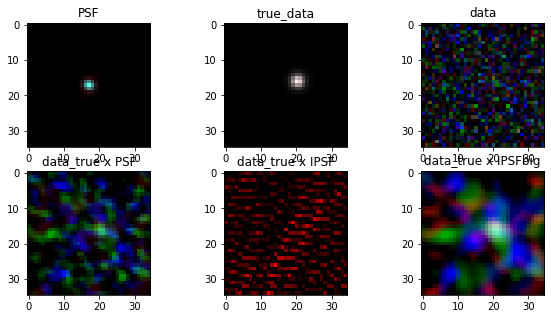

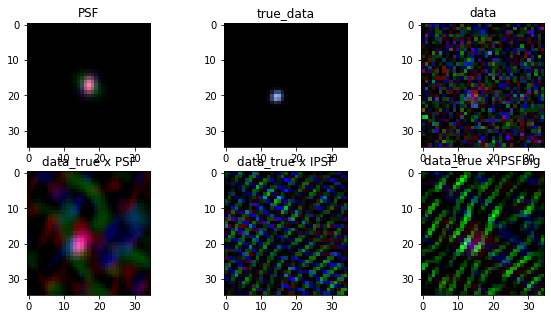

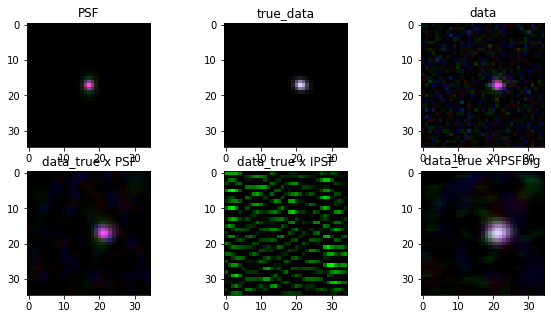

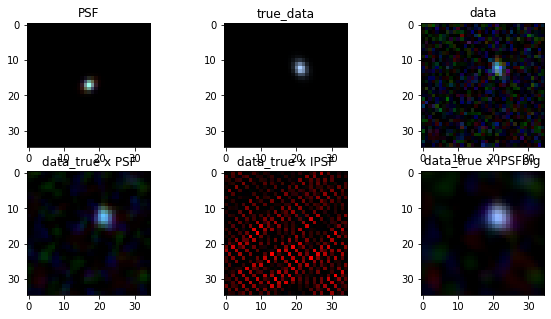

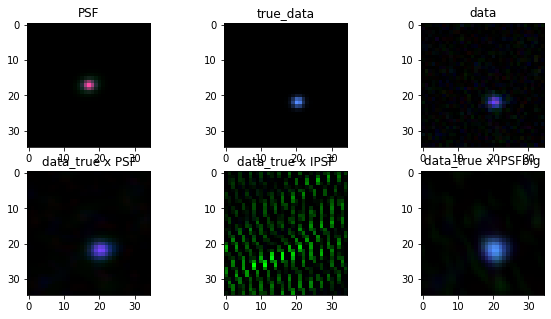

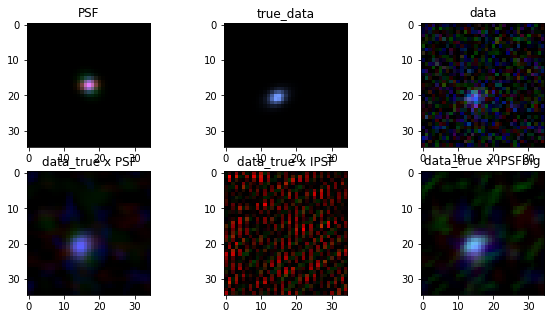

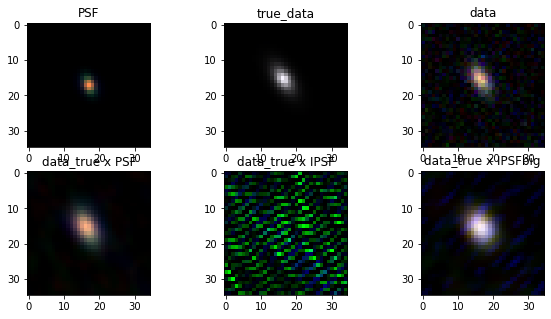

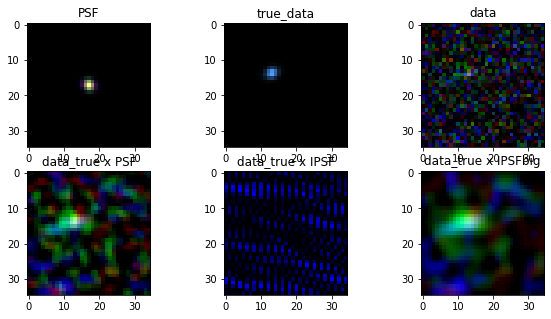

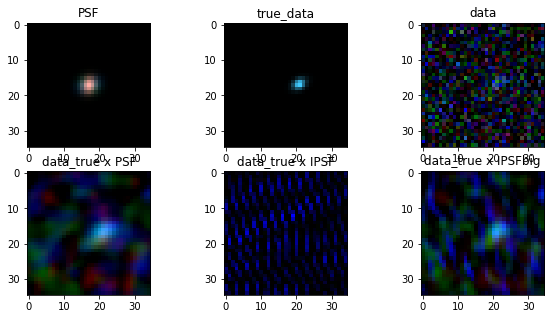

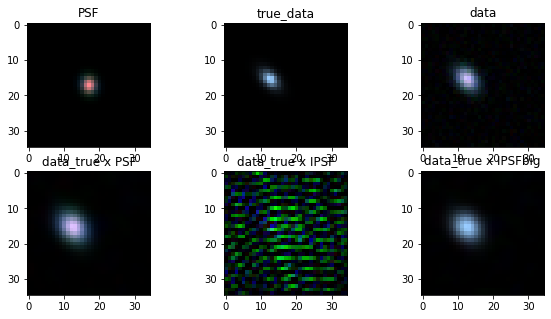

In [219]:
for g in c:
    plt.figure(figsize=(10,5))
    g.plot_rgb()